# Task Sequencer

This is a tool which will calculate the optimal order to approach tasks in a project where there are several different tasks that need to be done that have a certain probability of failing and will take a certain time to complete.

When we are uncertain about the feasibility of a project, we should strive to get as much information about the difficulty as quickly as possible. This suggests starting with tasks with a high failure rate.

The idea behind this approach is and some other useful information is discussed here. =https://cs.stanford.edu/~jsteinhardt/ResearchasaStochasticDecisionProcess.html

## Setup

### What you need to use this tool.

1. From the Anaconda Navigator, install Jupyter Lab if it's not already installed.
2. Go to the environments tab on the anaconda navigator. Switch installed to not installed and search for and install the following packages
    1. pandas
    2. nodejs
    3. ipywidgets
3. Go to the Anaconda Prompt and install ipysheets by entering the following command:

conda install -c conda-forge ipysheet

3. Go to Jupyter Lab. Open a new terminal. Enter the following command to get ipywidgets as an extension

jupyter labextension install @jupyter-widgets/jupyterlab-manager

4. After this has finished installing (it will take a few minutes) enter the following command to get ipysheets as an extension.

jupyter labextension install ipysheet

Now your ready to use the tool!

### Imports and settings

In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import ipywidgets
import ipysheet
import pandas as pd
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math

In [3]:
from time import process_time

### Data Entry

Add your data here just like you would on an Excel spreadsheet. 

Note: For the dependency columns, type the row numbers of the tasks that task A depends on in task A's dependencies (In the example, "Eat a frog" depends on "Eat a bigger one", and eat a bigger one is listed on row 2, so I put a 2 in d1, row 1).

Note: To adjust number of columns or number of rows, change the numbers in the code block below (default is 5 for each).

##### Important: provide your estimate for the probability of failing on the task, not succeeding.

In [148]:

rows = 6 # change as needed
columns = 10 # change as needed
labels = ['task', 'time', 'probability'] + ["d" + str(i + 1) for i in range(columns - 3)]
sheet = ipysheet.sheet(rows=rows, columns=columns, column_headers=labels)
data = [[None for i in range(columns)] for i in range(rows)]
ipysheet.cell_range(data)
sheet

Sheet(cells=(Cell(column_end=9, column_start=0, row_end=5, row_start=0, squeeze_column=False, squeeze_row=Fals…

Following code trims the dataframe to the values that the user put in.

In [172]:
df = ipysheet.to_dataframe(sheet)
df.fillna(0, inplace=True)
df.replace(to_replace=[''], value=0, inplace=True)
df.replace(to_replace=[None], value=0, inplace=True)
df.values
df.iloc[:,1:columns] = df.iloc[:,1:columns].astype(float)
deps = df.filter(like='d')
stop = np.where(np.sum(deps.values, 0)==0)[0][0]
df = df.iloc[0:rows,0:stop+3]
df

,task,time,probability,d1,d2,d3,d4
0,A,23.0,0.40,3.0,4.0,0.0,0.0
1,B,13.0,0.11,5.0,6.0,3.0,4.0
2,C,8.0,0.08,0.0,0.0,0.0,0.0
3,D,6.0,0.02,0.0,0.0,0.0,0.0
4,E,4.0,0.10,0.0,0.0,0.0,0.0
5,F,3.0,0.30,1.0,0.0,0.0,0.0


The table above should have all of the values you put in. The only difference will be that the blank dependencies now have a 0 in them.

## Code Body

Filters through all $n!$ permutations and elimintates those which violate a dependency.

Get an efficient size for the dependencies

In [173]:
deps = df.filter(like='d')# get nonzero dependencies
try:
    stop = np.where(np.sum(deps.values, 0)==0)[0][0]
    depMat = deps.values[:,:stop]
except IndexError:
    depMat = deps.values

In [174]:
perms = permutations(range(1,rows+1))
valid_perms = []
for perm in perms:
    prev_ind = [0]
    success = 0
    for index in perm:
        dep = depMat[index-1, :]
        sub_true = all(elem in prev_ind for elem in dep)
        if sub_true:
            prev_ind.append(index)
            success += 1
            continue
        else:
            break
    if success == df.shape[0]:
        valid_perms.append(perm)
        s = 1

In [175]:
valid_perms

[(3, 4, 1, 5, 6, 2),
 (3, 4, 1, 6, 5, 2),
 (3, 4, 5, 1, 6, 2),
 (3, 5, 4, 1, 6, 2),
 (4, 3, 1, 5, 6, 2),
 (4, 3, 1, 6, 5, 2),
 (4, 3, 5, 1, 6, 2),
 (4, 5, 3, 1, 6, 2),
 (5, 3, 4, 1, 6, 2),
 (5, 4, 3, 1, 6, 2)]

In [176]:
sums = []
for perm in valid_perms:
    prob = df['probability'][np.array(perm) - 1].values
    time = df['time'][np.array(perm) - 1].values
    pmat = np.tril(np.repeat(np.expand_dims((1-prob), 0), repeats=prob.shape[0], axis=0))
    np.fill_diagonal(pmat, 0)
    ones = np.triu(np.ones(np.shape(pmat)))
    np.fill_diagonal(ones, 0)
    pprod = np.prod(ones + pmat + np.diag(prob), 1)
    tmat = np.tril(np.repeat(np.expand_dims(time, 0), repeats=time.shape[0], axis=0))
    np.fill_diagonal(tmat, 0)
    tsum = np.sum(tmat, 1)
    sums.append(np.sum(pprod*(tsum + 
                        (np.log((1 - prob)**(1-prob)) + prob)/(np.log((1/(1-prob))**prob)))))

In [177]:
task_order = np.argsort(sums)
sorted_sums = np.sort(sums)

## Report

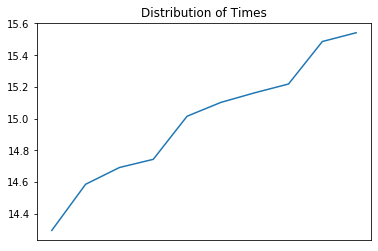

In [178]:
fig, axs = plt.subplots(1, 1)
axs.plot(np.arange(len(sorted_sums)), sorted_sums)
plt.xticks([])
plt.title('Distribution of Times')
plt.show()

# Alternative Algorithm

Get optimal ordering

Overview of Algorithm:
1. Find optimal ordering (simply by arranging the lambdas)
2. Compute the "maximaly helpful swaps" for getting dependencies in order.
3. If maximaly helpful swaps is empty:
    1. Return order
4. Otherwise
    1. Get new arrangements
    2. Compute which one is best.
    3. Repeat step 2 using this as optimal lambda.
    

In [179]:
prob = df['probability'].values
time = df['time'].values
lambind = np.flip(np.argsort(1/time*np.log(1/(1-prob)))) + 1#get ordered lambdas

In [180]:
def optimize(lambi, prev=np.zeros([1,df.shape[0]])):
    flips = get_flips(lambi, depMat)
    if flips.size==0:
        new_lambis = flip_them(lambi, np.array(list(range(len(lambi) - 1))))
        new_lambis = np.append(new_lambis, np.expand_dims(lambi, 0), 0).astype(int)
        valid_perms = validate_perms(new_lambis)
        print(valid_perms)
        sums = compute_time(valid_perms)
        best = valid_perms[np.argmin(sums)].astype(int)
        return best
    new_lambis = flip_them(lambi, flips)
    new_lambis = check_unique(new_lambis, prev)
    sums = compute_time(new_lambis)
    best = new_lambis[np.argmin(sums)].astype(int)
    prev = np.append(prev, np.expand_dims(best, 0), 0)
    return optimize(best, prev=prev)
    

In [181]:
def check_unique(new_lambis, prev):
    for i, row in enumerate(new_lambis):
        if (prev==row).all(axis=1).any():
            new_lambis[i,:] = np.zeros(new_lambis.shape[1])
    new_lambis = new_lambis[~np.all(new_lambis==0, axis=1)]
    return new_lambis

In [182]:
def validate_perms(perms):
    valid_perms = []
    for perm in perms:
        prev_ind = [0]
        success = 0
        for index in perm:
            dep = depMat[index-1, :]
            sub_true = all(elem in prev_ind for elem in dep)
            if sub_true:
                prev_ind.append(index)
                success += 1
                continue
            else:
                break
        if success == df.shape[0]:
            valid_perms.append(perm)
            s = 1
    return valid_perms

In [183]:
def compute_time(perms):
    '''Computes the time for each permutation of the rows in perms'''
    sums = []
    for perm in perms:
        prob = df['probability'][perm - 1].values
        time = df['time'][perm - 1].values
        pmat = np.tril(np.repeat(np.expand_dims((1-prob), 0), repeats=prob.shape[0], axis=0))
        np.fill_diagonal(pmat, 0)
        ones = np.triu(np.ones(np.shape(pmat)))
        np.fill_diagonal(ones, 0)
        pprod = np.prod(ones + pmat + np.diag(prob), 1)
        tmat = np.tril(np.repeat(np.expand_dims(time, 0), repeats=time.shape[0], axis=0))
        np.fill_diagonal(tmat, 0)
        tsum = np.sum(tmat, 1)
        sums.append(np.sum(pprod*(tsum + 
                            (np.log((1 - prob)**(1-prob)) + prob)/(np.log((1/(1-prob))**prob)))))
    return sums

In [184]:
def flip_them(lambi, flips):
    """returns a matrix where each row
    is the result of flipping lambi with
    one of the flips"""
    new = np.zeros([len(flips), len(lambi)])
    for count, i in enumerate(flips):
        temp = lambi.copy()
        temp[i], temp[i + 1] = temp[i + 1], temp[i]
        new[count,:] += temp
    return new    

In [185]:
def find_parents(row, lambi):
    '''Returns the inidicies of lambi where
    the tasks that task in row is dependent on
    are located'''
    deps = depMat[row-1] #minus 1 cause index
    parent_rows = deps[np.nonzero(deps)] #rid zeros
    parent_loc = np.where(np.in1d(lambi, parent_rows))[0]
    return parent_loc

In [186]:
def find_kids(row, lambi):
    '''Returns the inidicies of lambi where
    the dependents of task in "row" are located'''
    child_rows = np.argwhere(depMat==row)[:,0] + 1
    child_loc = np.where(np.in1d(lambi, child_rows))[0]
    return child_loc

In [187]:
def calc_bias(loc, kid_loc, par_loc):
    '''returns the net bias to move to
    the right'''
    l_bias = (kid_loc<loc).sum()
    if (par_loc==loc-1).any() and l_bias!=0:
        l_bias -= 1/2
    r_bias = (par_loc>loc).sum()
    if (kid_loc==loc+1).any() and r_bias!=0:
        r_bias -= 1/2
    return r_bias - l_bias

In [188]:
def get_flips(lambi, depMat):
    '''Returns the set of flips with
    the largest bias'''
    biases = []
    flip_biases = []
    for i in lambi:
        kid_loc = find_kids(i, lambi)
        par_loc = find_parents(i, lambi)
        loc = np.argwhere(lambi==i)[0]
        biases.append(calc_bias(loc, kid_loc, par_loc))
    for j in range(len(biases)-1):
        flip_biases.append(biases[j] - biases[j+1])
    flip_biases=np.array(flip_biases)
    if (flip_biases>0).sum()>0:
        return np.argwhere(flip_biases==np.amax(flip_biases)).flatten()
    else:
        return np.array([])

In [189]:
valid_perms[task_order[0]]

(5, 3, 4, 1, 6, 2)

In [190]:
optimize(lambind)

[array([3, 5, 4, 1, 6, 2]), array([5, 4, 3, 1, 6, 2]), array([5, 3, 4, 1, 6, 2])]


array([5, 3, 4, 1, 6, 2])

Algorithm Overview
1. Get the optimal ordering of lambdas
2. For each lambda element
    1. Find all parents to the left.
    2. Find all children to the right.
    3. Subtract left from right (to get net bias to the left)
3. For each i, i+1 pair in the lambda indices
    1. Compute i's net balance minus i+1's net balance (will get total bias of flip)
4. For each of these
    1. 

Cumulative distribution function given by $-e^{-\lambda T}$

Our algorithm will test all of the valid permutations and try to minimize
    $\text{E}[T_f]$,
Where $T_f$ is the time until we fail. This q

## Appendix A

We want to calculate the expected time to termination for a given sequence of $n$ tasks. We either terminate by completing all of our tasks or failing on one of them. Let $T$ be the random variable denoting time until termination. $S$ be a random variable indicating whether we have succeeded or not.
From the law of total expectation, 

$$
\text{E}[T] = \text{E}[\text{E}[T \vert S]] = \text{P}(S = 1)\text{E}[T \vert S = 1] + \text{P}(S = 0)\text{E}[T \vert S = 0].
$$

To start we will focus our calculation on $\text{E}[T \vert S = 0]$. Let $L_i$ be the event that we fail on the $i^{\text{th}}$ task, for $i \in \{ 1, \dots, n\}$. Observe that the possible events given we fail are $L_1, \dots, L_n$. Thus, $L_1, \dots, L_n$ partitions $\{S = 0\}$. This means that we can apply the law of total expectation again to yield


$$
\text{E}[T \vert S = 0] = \text{P}(L_1)\text{E}[T \vert L_1] + \dots + \text{P}(L_n)\text{E}[T \vert L_n].
$$

$\text{P}(L_i)$ is determined by the probability of getting to task $i$ and the probability of failing at task $i$. It can be calculated with

$$
\text{P}(L_i) = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}).
$$

Next, to calculate $\text{E}[T \vert L_i]$, let the starting time $t_{s}$ denote the time at which we start the $i^{\text{th}}$ task. Let $t_{i}$ denote the time the $i^{\text{th}}$ task takes us. Let $T_{i}$ be the random variable denoting the time spent on task $i$ given that we fail on task $i$. Suppose that the task fails at a rate $\lambda$ which is independent of how long we have been working on it. Then $f(t) = \lambda e^{-\lambda t}$ is the probability density function for failure time if the task is allowed to continue indefinately until we fail. We have assumed that the task will fail before $t_{i}$. It therefore follows that the probability density function for $T_{i}$ is $f(t \vert t< t_{i})$. This function has is given by

$$
f(t \vert t \leq t_{i})= \begin{cases}
\frac{1}{A}\lambda e^{-\lambda t}, \hspace{1cm} 0 \leq t \leq t_{i}, \\
0, \hspace{1.8cm} \text{otherwise}.
\end{cases}
$$

Where $A$ denotes the area under the curve of $f(t)$ from $0$ to $t_{i}$. To calculate $A$, we have

$$
A = \int_0^{t_{i}} \lambda e^{-\lambda t} dt = 1 - e^{-\lambda t_{i}}.
$$

To calculate $\text{E}[T]$ we now have

$$
\text{E}[T \vert L_i] = t_0 + \frac{1}{ 1 - e^{-\lambda t_{i}}} \int_0^{t_{i}} \lambda t e^{-\lambda t} dt,
$$

which after some simplification yeilds

$$
\text{E}[T \vert L_i] = t_0 + \frac{1 - t_{i} \lambda e^{-\lambda t_{i}} - e^{-\lambda t_{i}}}{\lambda(1 - e^{-\lambda t_{i}})}.
$$

$\lambda$ is currently an unknown value. The values we are given are $t_i$ and the probability of failure $p_i$. We need to write $\lambda$ in terms of these known quantities. This can be done with the following equation.

$$
1 - e^{- \lambda t_i} = p_{i},
$$

which yields

$$
\lambda = \frac{1}{t_i}\ln \Big{(}\frac{1}{1 - p_{i}}\Big{)}
$$

By substituting this value of $\lambda$ into the above equation and simplifying we get

$$
\text{E}[T \vert L_i] = t_0 + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}}.
$$

Thus, $\text{P}(L_i)\text{E}[T \vert L_i]$ is given by

$$
\text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}t_0 + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)}.
$$

Note that for each $i \in \{1, \dots n\}$, $t_0$ is the time to complete the $1^{\text{st}}$ through $i - 1^{\text{th}}$ task. Then we can write $t_0$ as

$$
t_0 = \sum_{j = 1}^{i - 1} t_j.
$$

This implies that our final equation for $\text{P}(L_i)\text{E}[T \vert L_i]$ is given by

$$
\text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)}.
$$

To find $\text{E}[T \vert S = 1]$, we must simply sum through all of the terms.

$$
\text{E}[T \vert S = 1] = \sum_{i = 1}^n \Bigg{(} \text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)} \Bigg{)}
$$

Next, by looking at the complement of $\text{P}(S = 0)$ we have

$$
\text{P}(S = 0) = 1 - \text{P}(S = 1) = 1 - \prod_{i = 1}^{n} (1 - p_i).
$$

$\text{E}[T \vert S = 1]$ is simply the expected time to success, which is simply the sum of the expected times to complete each task given by

$$
\text{E}[T \vert S = 1] = \sum_{i = 1}^n t_i
$$

Putting all of this together, we find

$$
\text{E}[T] = \Big{(}1 - \prod_{i = 1}^{n} (1 - p_i)\Big{)}\sum_{i = 1}^n t_i + \prod_{i = 1}^{n} (1 - p_i) \Bigg{(} \sum_{i = 1}^n \Bigg{(} \text{P}(L_i)\text{E}[T \vert L_i] = p_i \prod_{k = 1}^{i - 1} (1 - p_{k}) \Bigg{(}\sum_{j = 1}^{i - 1} t_j + \frac{t_i\big{(}\ln\big{(}(1 - p_i)^{1 - p}\big{)} + p_i\big{)}}{\ln\Big{(}\big{(}\frac{1}{1-p_{i}}\big{)}^{p_{i}}\Big{)}} \Bigg{)} \Bigg{)} \Bigg{)}
$$

## Appendix B

#### Lemma 1:
<i>Let</i> $S_0 = s_1, \dots s_j, s_{j + 1}, \dots s_n$, $S_1 =  s_1, \dots s_{j + 1}, s_{j} + \dots + s_{n}$<i>be a sequence of tasks with</i> $n \geq 2$. Let $\lambda_i$ be the failure rate of task $s_i$, for $i \in \{1 \dots n\}$. Then $\lambda_j > \lambda_{j + 1}$ if and only if $\text{E}[T \vert s_1, \dots s_j, s_{j + 1}, \dots s_n] < \text{E}[T \vert s_1, \dots s_{j + 1}, s_{j}, \dots s_n]$.

<i>proof</i>
$\Rightarrow$
Consider the events $\text{E}_1 = L_1 \cup \dots \cup L_{j - 1}, \text{E}_2 = L_j \cup L_{j + 1}$, and $\text{E}_3 = L_{j + 2} \cup \dots \cup L_n$ Observe $\Omega = \text{E}_1 \cup \text{E}_2 \cup \text{E}_3 \cup S_0$. This implies $\text{E}[T|S_0] = \text{P}(\text{E}_1 \vert S_0)\text{E}[T \vert \text{E}_1,S_0] + \text{P}(\text{E}_2 \vert S_0)\text{E}[T \vert \text{E}_2,S_0] + \text{P}(\text{E}_3 \vert S_0)\text{E}[T \vert \text{E}_3,S_0]$.  Observe that $f(T|\text{E}_1, S_0) = f(T|\text{E}_1, S_1), f(T

### Theorem 1: 
<i>Let $s_1, \dots s_n$ be a sequence of tasks such that $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_n$. Let S_n be the set of permutations </i>